# MA755 - Assigment 1 - Predict The average annual total cost of attendance 

by *Ignacio Carracedo and Nan Wang*


## SUMMARY

This notebook builts a model that predicts the average annual total cost of attendance for institutions primarily following an academic year-based calendar system. The average annual cost of attendance includes tuition and fees, books and supplies, and living expenses for all full-time, first-time, degree-/certificate-seeking undergraduates who receive Title IV aid.
We would like to what features such as the institution's location, dregrees offered, size, its students' demography, etc, have more influence in the attendance cost. In addition, we explore how to predict the cost.


**Prelude**: Show the Py notebook running enviroment and versions of the libraries we are working with.

In [1]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn

2017-02-12 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [7]:
# IMPORTS
import os
from os import listdir
from os.path import isfile, join
import zipfile
from six.moves import urllib

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

The college data set can be downloaded from 'https://collegescorecard.ed.gov/data/'. Data is compress in a zip file that has a *.csv* file per school year.

In [8]:
# Variables that store the location of the data in the web and where it will be downloaded in our local project folder
DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/downloads/"
COLLEGE_PATH = "datasets/collegescorecard"
COLLEGE_URL = DOWNLOAD_ROOT+ "/CollegeScorecard_Raw_Data.zip"

The following funtion will:

* Download dataset into datasets\collegescorecard\CollegeScorecard_Raw_Data folder.
* Extract zip file

In [4]:
def fetch_housing_data(college_url=COLLEGE_URL, college_path=COLLEGE_PATH):
    """ downloads data from college_url and unzip it into college_path"""
    
    os.makedirs(college_path, exist_ok=True)
    zip_path = os.path.join(college_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path, 'r')
    college_zip.extractall(path=college_path)
    college_zip.close()

In [ ]:
fetch_housing_data()

There is one csv file for each school year, the following funtion reads the .csv files separatly and concatenate them to one data frame. During this process a YEAR column is added to show the school year of each observation. the Funtion also takes a string as an argument and will only concatenate files that have that string in their name. 

Because of memory issues, we pass the string *'201'* to the function to select a subset of the files, the ones for 2010 and after.

In [9]:
def load_college_data(college_path=COLLEGE_PATH+'/CollegeScorecard_Raw_Data', string_include = "" ):
    """ downwloads data from college_url and unzip it into college_path"""
    college_list = []
    #get list of files in directory that are .csv and starting 2000 (memory issues)
    onlyfiles = [f for f in listdir(college_path) if (isfile(join(college_path, f)))
                 and (".csv" in f) and ("201" in f)]
    
    for f in onlyfiles:
        print("Reading %s ..." %f)
        csv_path = os.path.join(college_path, f)
        aux = pd.read_csv(csv_path,low_memory=False)
        aux['YEAR']=int(f.split('MERGED')[1].split('_')[0])
        college_list.append(aux)
        del aux 
    print("Concatenating files ...")    
    return pd.concat(college_list)

In [10]:
#get a list of files in directory that are .csv in and after 2010
college = load_college_data(string_include="201")

Reading MERGED2010_11_PP.csv ...
Reading MERGED2011_12_PP.csv ...
Reading MERGED2012_13_PP.csv ...
Reading MERGED2013_14_PP.csv ...
Reading MERGED2014_15_PP.csv ...
Concatenating files ...


Now we have one data frame with all the data. We save the dataframe so we don't have to repeat this process again. This will allow us to start this notebook from this cell if we uncomment the read_csv line in the next cell:

In [7]:
college.to_csv(COLLEGE_PATH+'/college.csv',index=False) #save

In [ ]:
#college = pd.read_csv(COLLEGE_PATH+'/college.csv', encoding = "ISO-8859-1") #read

We can now check the size of the data frame and explore the first 5 columns to get a general idea of what it looks like

In [11]:
print("Rows: %s, Columns: %s " %(college.shape[0],college.shape[1]))
college.head()

Rows: 38389, Columns: 1744 


,﻿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM,YEAR
0,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0,2010
1,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0,2010
2,100690,02503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0,2010
3,100706,00105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0,2010
4,100724,00100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0,2010


Check the non-missing average annual cost (COSTT4_A) change over the 5 years using box plots and also check that the insitutions that have the feature COST are the same for all the years.

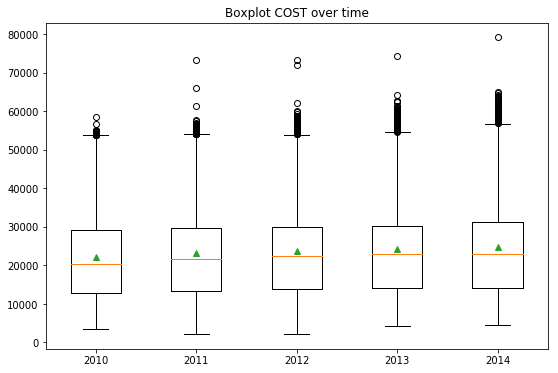

' ******** All years have the same institutions with the feature cost ******** '

In [52]:
def institutions_cost_years (df):
    """ Function that gets a dataframe as inmput and returns if the institutions with feature COSTT4_A
    are the same for each year or if at least one is differnt. It returns a string with a message."""
    # create sorted list with all institutions with feature cost for each year
    total = [sorted(list(df[df.YEAR==2014].ix[:, 0].dropna(axis=0).unique())) for x in df.YEAR.unique()] 
    #return result
    if all(x == total[0] for x in total):
        return(" ******** All years have the same institutions with the feature cost ******** ")
    else:
        return("******** Not all years have the same institutions with the feature cost ******** ")
    
###### BOXPLOT of COSTT_A over time
year_cost_data = []

for y in college.YEAR.unique():
    year_cost_data.append(college[college['YEAR']==y]["COSTT4_A"].dropna(axis=0))
    
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
ax.boxplot(year_cost_data, showmeans=True)
plt.title("Boxplot COST over time")
plt.xticks(range(1,6),list(college.YEAR.unique()))
plt.show()

# check for same institutions
institutions_cost_years(college)

The mean and percentiles (0, 25, 50, 75, 100) of the annual average cost all increased in the 2014-2015 school year compared to 2010-2011 school year. Therefore, we are going to use the data from 2014-2015 school year since it is the most up todate and do not consider prior year's information. Also, each years has the same institutions (checked with *institutions_cost_years* funtion)

A data frame containing 2014-2015 school year information is created below.

In [53]:
college2014 = college[college['YEAR']==2014] #filer
college2014.to_csv(COLLEGE_PATH+'/college2014.csv',index=False) # save
del college # delete to save memory

Next time we run the notebook we could start using the following cell that loads the data of 2014 back in. It will be faster.

In [9]:
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv', encoding = "ISO-8859-1", low_memory=False)

## Data Exploration / Feature selection

Investigate missing values. Next cell defines a funtion to return the data frame with all the columns that have a percentage of missing values below a threashold. We will use this funtion to select feautures to feed into our machine learning algorithm because the features with fewer missing values are likely more useful/important.

Since the annual average cost COSTT4_A is the target variable  we select the subset where COSTT4_A is not missing.

In [55]:
college2014 = college2014.dropna(axis=0, subset=["COSTT4_A"])
print("Rows: %s, Columns: %s " %(college2014.shape[0],college2014.shape[1]))

Rows: 4030, Columns: 1744 


We end up with 4030 observations after dropping any missing values for the annual average cost.

In [65]:
def cols_few_missing_values(df, threshold=0):
    
    '''this function takes a DataFrame and a threshold as parameters and 
       returns the DataFrame with the columns that have a percentage of
       missing values equal or less than the threshold'''

    columns = []
    total_rows = college2014.shape[0]
    missing_values = dict(college2014.isnull().sum())
    
    for key, value in missing_values.items():
        if (value/total_rows) <= threshold:
            columns.append(key)    
            
    df = df[columns]
    print("*** Keeping %s out of %s columns with missing values threashold of %s ***\n"
          %(len(columns), total_rows, threshold))
    return (df)

Using the missing value funtion we constructed above we can check which columns have few missing values. We set the theashold of missing values to 10% and reduced the features to 326. 

*NOTE*: Output is trimmed to 50 columns.

In [66]:
for i in (np.sort(cols_few_missing_values(college2014,0.1).columns))[:50]:
    print(i)
print("\n----- output trimmed -----")

*** Keeping 468 out of 4030 columns with missing values threashold of 0.1 ***

AANAPII
ACCREDAGENCY
AGE_ENTRY
ANNHI
APPL_SCH_N
APPL_SCH_PCT_GE2
APPL_SCH_PCT_GE3
APPL_SCH_PCT_GE4
APPL_SCH_PCT_GE5
AVGFACSAL
CCBASIC
CCSIZSET
CCUGPROF
CDR3
CDR3_DENOM
CIP01ASSOC
CIP01BACHL
CIP01CERT1
CIP01CERT2
CIP01CERT4
CIP03ASSOC
CIP03BACHL
CIP03CERT1
CIP03CERT2
CIP03CERT4
CIP04ASSOC
CIP04BACHL
CIP04CERT1
CIP04CERT2
CIP04CERT4
CIP05ASSOC
CIP05BACHL
CIP05CERT1
CIP05CERT2
CIP05CERT4
CIP09ASSOC
CIP09BACHL
CIP09CERT1
CIP09CERT2
CIP09CERT4
CIP10ASSOC
CIP10BACHL
CIP10CERT1
CIP10CERT2
CIP10CERT4
CIP11ASSOC
CIP11BACHL
CIP11CERT1
CIP11CERT2
CIP11CERT4

----- output trimmed -----


Then we went through the features, further reducing them using the common knowlege regarding which factors might affect college attendance cost and which ones we were intersted in exploring:

We selected the following 77 feaures to model:

* CONTROL: Public, Private nonprofit, Private for-profit
* MAIN: Flag for main campus
* REGION: REGION
* ICLEVEL: institutional_characteristics.level 4-year,2-year,Less-than-2-year
* NUMBRANCH: Number of branch campuses
* PREDDEG: "Predominant undergraduate degree awarded 0 Not classified 1 Predominantly certificate-degree granting 2 Predominantlyassociate's-degree granting 3 Predominantly bachelor's-degree granting 4 Entirely graduate-degree granting"
* HIGHDEG: "Highest degree awarded 0 Non-degree-granting 1 Certificate degree 2 Associate degree 3 Bachelor's degree 4 Graduate degree"
* PBI: Flag for predominantly black institution
* MENONLY
* WOMENONLY
* PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09", "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22", "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38", "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47", "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54" : types of degrees offered.
* UGDS_2MOR
* UGDS_AIAN
* UGDS_ASIAN
* UGDS_BLACK
* UGDS_HISP
* UGDS_MEN
* UGDS_NHPI
* UGDS_NRA
* UGDS_UNKN
* UGDS_WHITE
* UGDS_WOMEN
* UG: Enrollment of all undergraduate students
* UGDS: Enrollment of undergraduate certificate/degree-seeking students

In [67]:
# feature selection
columns = ['COSTT4_A','CONTROL', 'MAIN', 'REGION', 'ICLEVEL', 'NUMBRANCH','PREDDEG','HIGHDEG',
           'MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09",
           "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22",
           "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38",
           "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR", "UGDS_AIAN",
           "UGDS_ASIAN", "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", 
           "UGDS_WHITE", "UGDS_WOMEN", "UGDS"]

college2014 = college2014[columns]

Exploring the REGION feature we found that there is only one school at region 0:

In [68]:
college2014.REGION.value_counts().sort_values().head(10)

0.0       1
9.0     107
7.0     150
1.0     234
6.0     349
4.0     414
8.0     499
3.0     598
2.0     633
5.0    1045
Name: REGION, dtype: int64

Thus we remove this one record from analysis during the data split below.

Before modeling, we will split the dataset into a traning set that we will use to train our model and a test set to test the goodness of the model, which we will set aside for final model testing with unseen data.

Since CONTROL, whether a college is public or private, has a lot of impact on the annual attendance cost, we split the data stratified by CONTROL.

In [69]:
def split(X):
    '''this function takes the college dataframe as  aparameters and 
       returns train/test sets as a tuple. Stritified based on state'''

    # region to same number for stratified split
    X = X[X["REGION"] != 0]
    #stratified split based on states
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    #split
    for train_index, test_index in split.split(X, X["CONTROL"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

train_set, test_set = split(college2014)

Let's verigy that the split was correct:

In [85]:
print("TRAIN SET proportion of  CONTROL feature:")
print(train_set.CONTROL.value_counts()/train_set.shape[0])
print("\nTEST SET proportion of  CONTROL feature:")
print(test_set.CONTROL.value_counts()/test_set.shape[0])

TRAIN SET proportion of  CONTROL feature:
1    0.401489
2    0.346572
3    0.251939
Name: CONTROL, dtype: float64

TEST SET proportion of  CONTROL feature:
1    0.401985
2    0.346154
3    0.251861
Name: CONTROL, dtype: float64


Let's explore the variables with higher correlation (20) with the target variable

In [86]:
corr_matrix = train_set.corr()
corr_matrix["COSTT4_A"].sort_values(ascending=False)[:20]

COSTT4_A      1.000000
HIGHDEG       0.477874
PREDDEG       0.450112
PCIP26        0.445769
PCIP23        0.435755
PCIP45        0.431666
CONTROL       0.424588
PCIP54        0.410152
PCIP27        0.397268
PCIP40        0.350952
UGDS_NRA      0.300321
PCIP16        0.298797
PCIP42        0.295581
PCIP09        0.244923
PCIP50        0.235398
PCIP14        0.160798
WOMENONLY     0.156337
PCIP05        0.155592
UGDS_ASIAN    0.153333
UGDS_UNKN     0.118507
Name: COSTT4_A, dtype: float64

As we thought, control along with other features as HIGHDEG, PREDDEG, etc have hight correlation with the target variable. Even though some variables are categorical there is still correlation beacause they are ordinal (See HIGHDEG, PREDDEG). 

Now we can check the historgram for each numeric feature. Most of our features are categorical and are encoded using an integer so the historgrams are not really helpful but it gives us a general idea of the data we are working with. We could try to use log transformation for the cost to make it more normally distributed. However, we are not going to do it for this first iteration of the analysis.

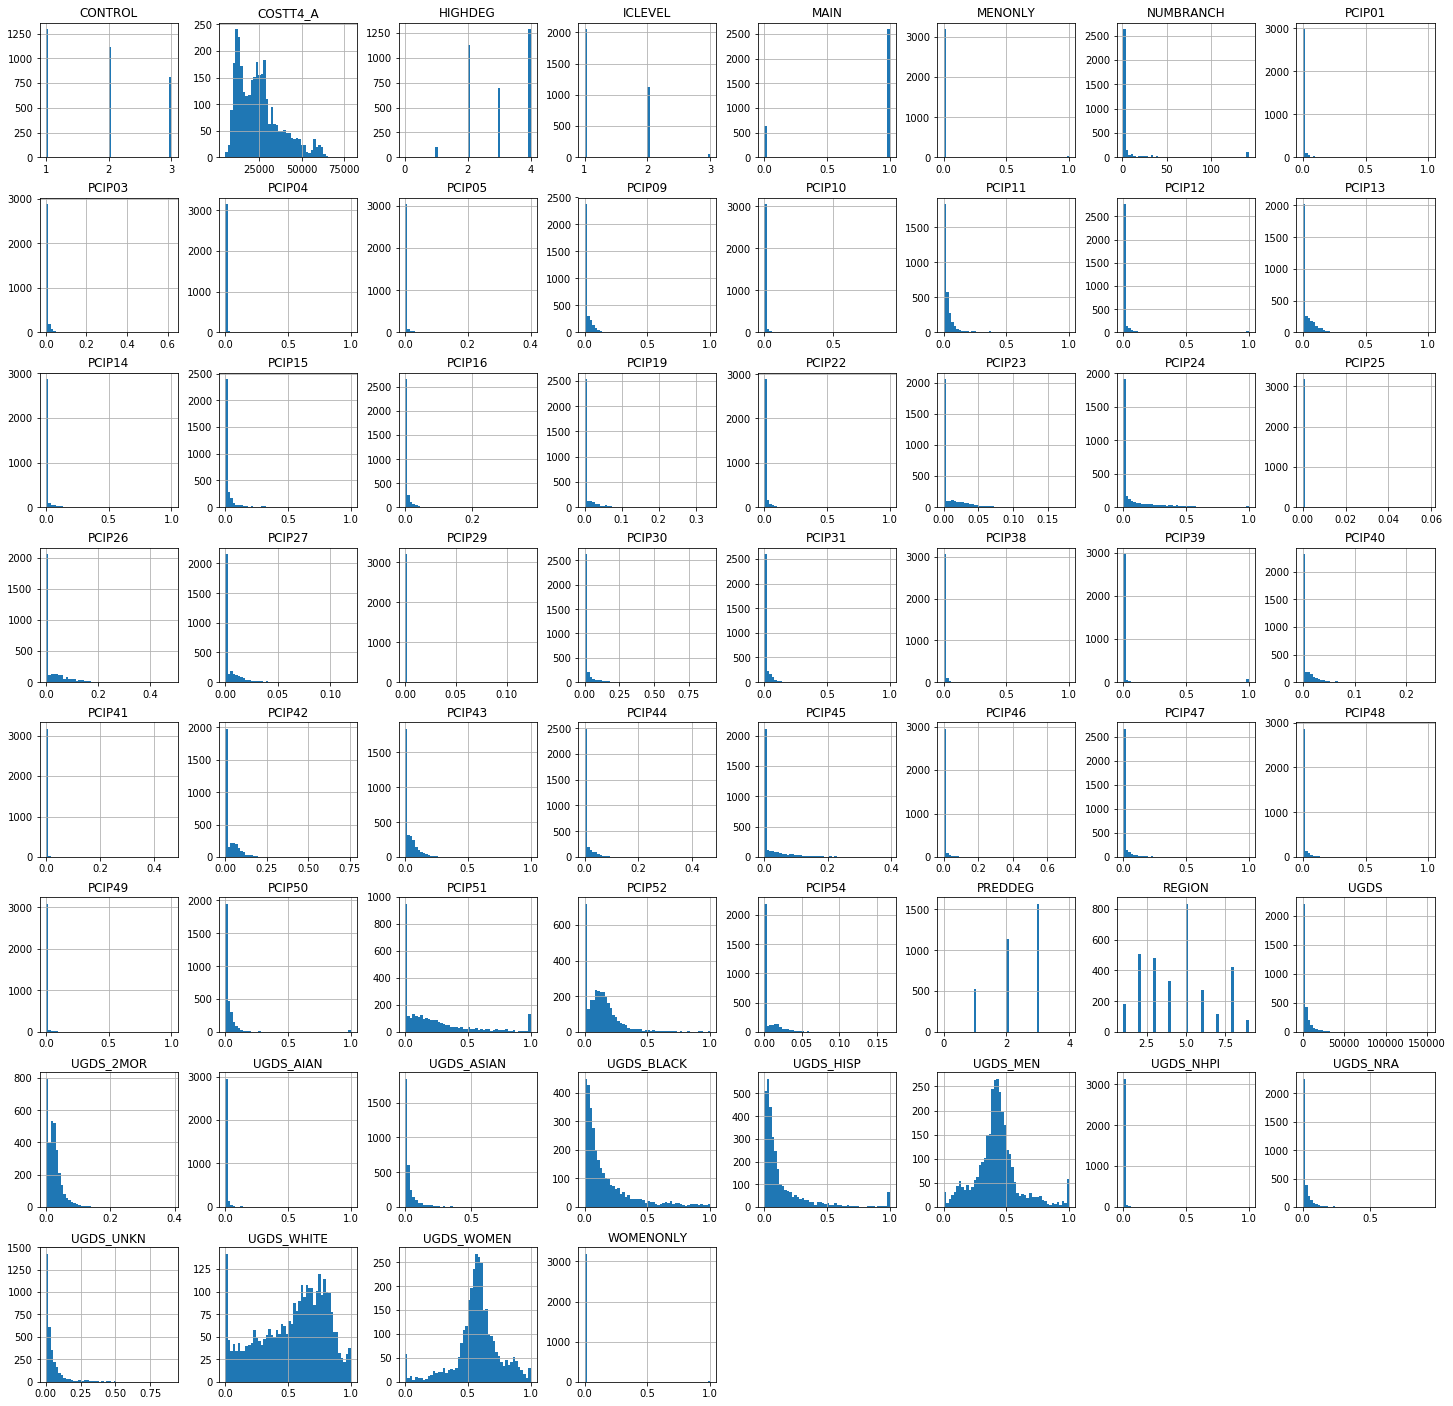

In [87]:
train_set.hist(bins=50, figsize=(25,25))
plt.show()

Let's explore more closely the target variable (COSTT4_A):

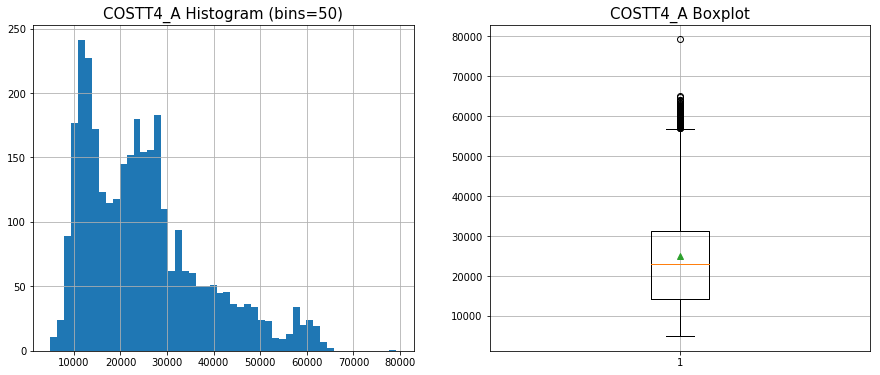

In [91]:
fig = plt.figure(figsize=(15,6))

#hist
ax1 = fig.add_subplot(121)
ax1.hist(train_set.COSTT4_A,bins=50)
ax1.grid(True)
plt.title("COSTT4_A Histogram (bins=50)", size=15)

#boxplot
ax2 = fig.add_subplot(122)
ax2.boxplot(train_set.COSTT4_A, showmeans=True)
ax2.grid(True)
plt.title("COSTT4_A Boxplot",  size=15)
plt.show()

Check scatter plots looking fo interesting patters

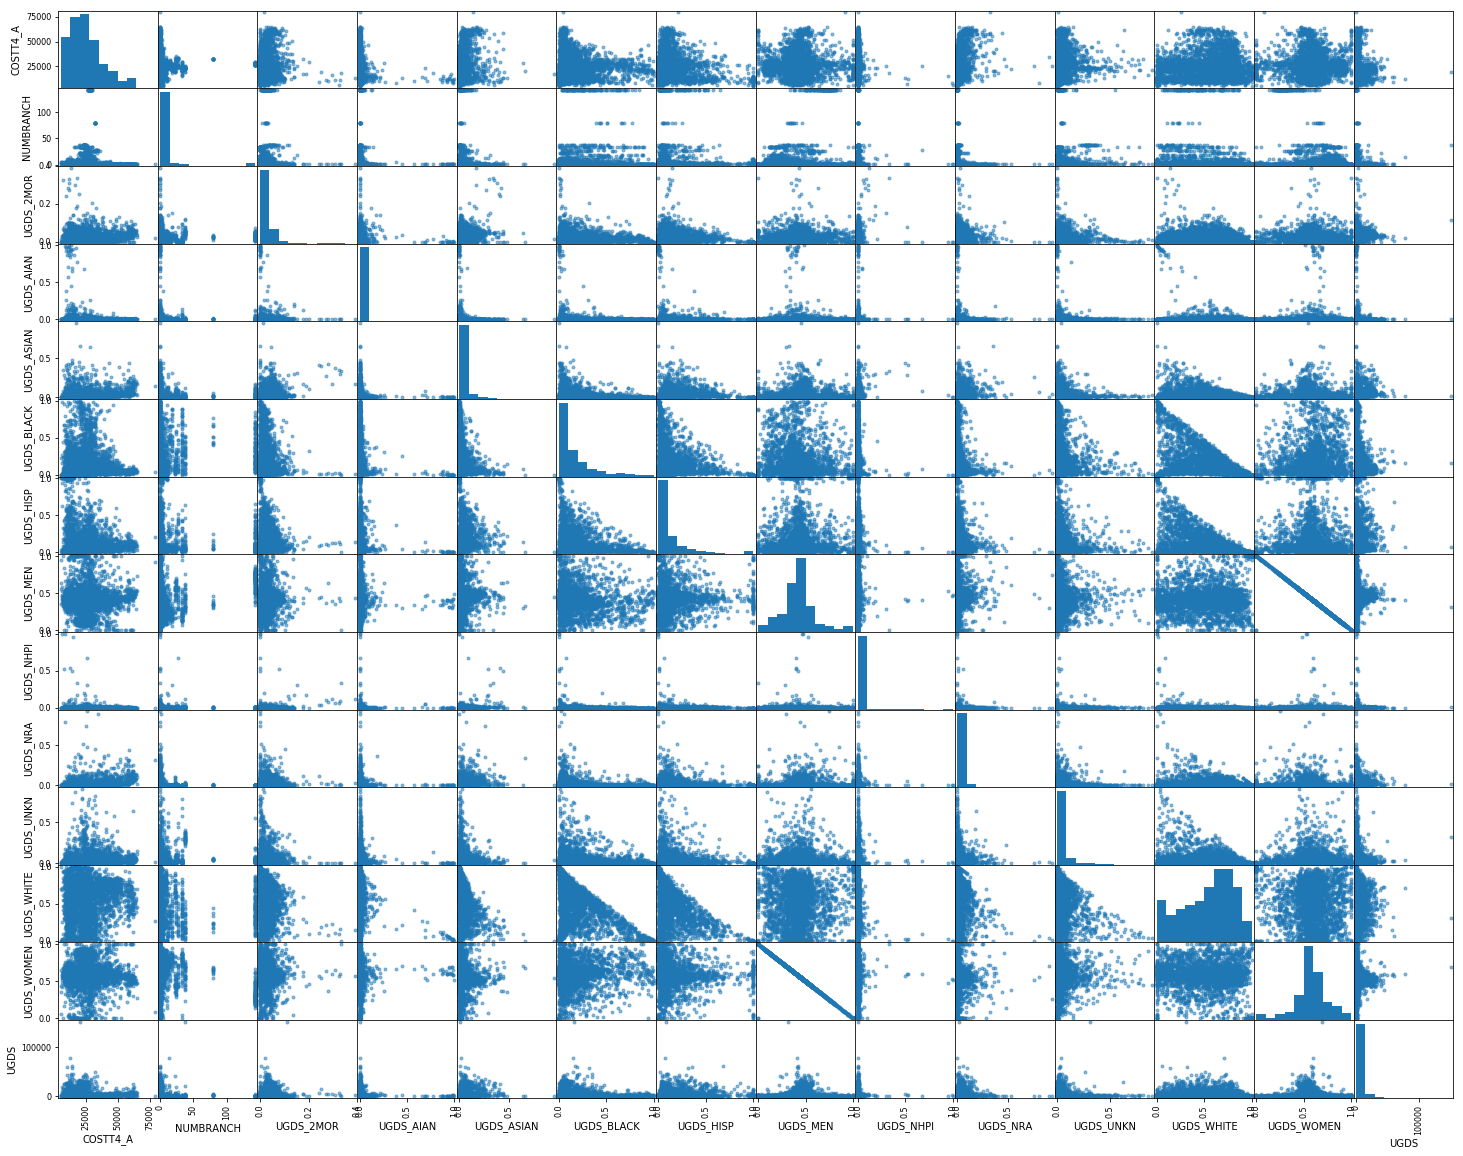

In [92]:
from pandas.tools.plotting import scatter_matrix

attributes = ["COSTT4_A", "NUMBRANCH","UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
              "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA",
              "UGDS_UNKN", "UGDS_WHITE", "UGDS_WOMEN","UGDS"]

scatter_matrix(train_set[attributes], figsize=(25, 20), alpha=0.5)
plt.show()

Not much correlation but at least we can see we don't need both UGDS woman and man. They look complementary, let's double check

In [121]:
# check first 5 values
train_set[["UGDS_MEN","UGDS_WOMEN"]].head()

,UGDS_MEN,UGDS_WOMEN
3728,0.3883,0.6117
1183,0.4641,0.5359
296,0.4618,0.5382
2876,0.5206,0.4794
5457,0.5000,0.5000


After doing some checks we are sure we can drop one of them becasue they carry the same information

In [34]:
train_set.drop("UGDS_WOMEN", 1, inplace=True)

Let check missing values:

In [122]:
print("TRAIN SET - Number of featues with at least 1 missing value: %s"
      %(train_set.isnull().sum() != 0).sum())
print("TEST SET - Number of featues with at least 1 missing value: %s"
      %(test_set.isnull().sum() != 0).sum())

TRAIN SET - Number of featues with at least 1 missing value: 0
TEST SET - Number of featues with at least 1 missing value: 0


We don't have any missing values. I've we had we'll have either remove them or use a imputation method (mean, median, regression, ...)

### Custom transformers

Until now we've been exploring the data set and we figured out all the neccesary steps we needed to get the data ready for  machine learning models. To simplify the data preparation we are going to create a pipeline that will get the original data and will output the transformed data we'll feed to our models. Our custom tranformers will inherit from sklearn classes (BaseEstimator, TransformerMixin) the folling methods: set_param, get_param, and fit_transform (method that it's used in the pipeline).

Our custom transformes will implement the same methods that sklearn classes: fit and transform. 

The transformer we need are:

* feature_selection: it will select the features we are using for our model.
* one_hot: it will one-hot-encode categorical features, merge them with the data frame, and delete the original feature

We will also create a funtion (split) to split the data set after the transformation. This split uses the same random seed as before.

In [149]:
from sklearn.base import BaseEstimator, TransformerMixin

class one_hot(BaseEstimator, TransformerMixin):
    
    def __init__(self): 
        self.control_encoder = OneHotEncoder(sparse=False)
        self.iclever_encoder = OneHotEncoder(sparse=False)
        self.region_encoder = OneHotEncoder(sparse=False)
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        X.reset_index(drop=True,inplace=True)
                
        CONTROL = self.control_encoder.fit_transform(X["CONTROL"].reshape(-1, 1))
        control_df = pd.DataFrame(CONTROL,
                                  columns=["CONTROL1","CONTROL2","CONTROL3"]).reset_index(drop=True)
        X = pd.concat([X, control_df], axis=1)
        X.drop("CONTROL",axis=1,inplace=True)
                
        ICLEVEL = self.iclever_encoder.fit_transform(X["ICLEVEL"].reshape(-1, 1))
        iclevel_df = pd.DataFrame(ICLEVEL,
                                  columns=["ICLEVEL1","ICLEVEL2","ICLEVEL3"]).reset_index(drop=True)
        X = pd.concat([X, iclevel_df], axis=1)
        X.drop("ICLEVEL",axis=1,inplace=True)
        
        
        REGION = self.region_encoder.fit_transform(X["REGION"].reshape(-1, 1))
        region_df = pd.DataFrame(REGION).reset_index(drop=True)
        X = pd.concat([X, region_df], axis=1)
        X.drop("REGION",axis=1,inplace=True)

        return X

    
class feature_selection(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        return X[self.attribute_names]

    
def split(X):
    """this function takes the college dataframe as  aparameters and 
       returns train/test sets as a tuple. Stritified based on state"""
    
    # region to same number for stratified split
    X = X[X["REGION"] != 0]
    #stratified split based on states
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    #split
    for train_index, test_index in split.split(X, X["CONTROL"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

## PIPELINE

Now that we have define our tranformers we can run our pipeline to get the transformed data. The pipeline will use the fit_transform method of each tranformer and will pass the output to the next step of the pipeline. Once done we use the split funtion to get our train and test set. 

Note that we from now on we can start executing the notebook from this cell. This is a summary of each step it takes:

1. Load data set.
* Drop nulls of target variable.
* Split into traning and test set.
* Feed data to pipeline:
    * feature selection.
    * one hot encoding.

In [151]:
# load data
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv',
                          encoding = "ISO-8859-1",low_memory=False)
college2014.dropna(axis=0, subset=["COSTT4_A"], inplace=True)

#columns to keep
columns = ['COSTT4_A','CONTROL', 'MAIN', 'REGION', 'ICLEVEL', 'NUMBRANCH','PREDDEG',
           'HIGHDEG','MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05",
           "PCIP09","PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15",
           "PCIP16", "PCIP19", "PCIP22","PCIP23", "PCIP24", "PCIP25", "PCIP26",
           "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38","PCIP39", "PCIP40",
           "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR",
           "UGDS_AIAN", "UGDS_ASIAN","UGDS_BLACK", "UGDS_HISP", "UGDS_MEN",
           "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE", "UGDS"]

#pipeline
college_pipeline = Pipeline([
        ('feature_selection', feature_selection(columns)),
        ('one_hot', one_hot()),
        #('std_scaler', StandardScaler()),
    ])

# run pipeline
train_set, test_set = split(college2014)
train_set = college_pipeline.fit_transform(train_set)
test_set = college_pipeline.fit_transform(test_set)

# check sets size
print("TRAIN SET rows: %s, columns: %s " %(train_set.shape[0],train_set.shape[1]))
print("TEST SET rows: %s, columns: %s " %(test_set.shape[0],test_set.shape[1]))

TRAIN SET rows: 3223, columns: 71 
TEST SET rows: 806, columns: 71 


## MODEL

Now that we have the training and test set we divide each one of them into target variable (y_train and y_test) and predictors (X_train, X_test)

In [153]:
X_train = train_set.drop("COSTT4_A", axis=1)
y_train = train_set["COSTT4_A"]
X_test = test_set.drop("COSTT4_A", axis=1)
y_test = test_set["COSTT4_A"]

## SELECT MODEL

The next step is to try several models (without hyperparameter tune up) to see which one yieds better results.

We'll use cross validation 20-folds to get the score for each model (mean of all folds). The score function we are using is negative mean square errors (opposite of MSE as CV expects a funtion where lower score is better).

Using this procedure we are going to try in the next 3 cells the following models:

* Linear regression
* Decision Tree
* Random Forest

In [154]:
tree_reg = DecisionTreeRegressor()

tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 6802.94523182  6206.67012223  5549.78011465  6376.79072207  7406.97140101
  6124.91404427  5727.38877176  6025.75308868  6942.10451426  6549.06253592
  6658.68332255  7137.00452719  7745.07943453  6378.9783324   7810.51790141
  7148.63929023  6436.03211691  6698.10713226  6206.32667235  7497.21610859]
Mean: 6671.44826926
Standard deviation: 622.456882127


In [155]:
lin_reg = LinearRegression()

tree_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 5718.57817742  6255.76029567  5019.52290474  6603.80442671  6877.23881039
  5561.58008819  5231.35985534  5943.23127455  5779.89097408  6516.96241474
  5481.43959443  6255.48448135  6178.4569915   5674.61193314  5226.76267305
  6284.27478846  6531.61774697  5653.78205118  5856.37314071  6286.72806993]
Mean: 5946.87303463
Standard deviation: 497.066455145


In [156]:
forest_reg = RandomForestRegressor()

tree_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 4965.75197113  5883.82226358  4362.77204286  5819.70202519  5858.09999891
  4269.3723247   4573.53235913  4122.64804545  4561.59328465  4396.79253246
  4595.49264877  5380.09757546  5770.28341934  4679.600836    4970.4968769
  5605.11478322  4873.00731171  4674.64453071  4275.89973325  6087.26202024]
Mean: 4986.29932918
Standard deviation: 625.856801899


The best model (using skilearn default values for model parameters) is Random Forest. This model yields better RMSE and smaller standard deviation which means it is more robust than the others. We will now tune up the hyperparameters of the selected model.

## TUNE MODEL

To tune up the hyperparameters we are going to do a Grid Search. Using crossvalidaton Grid Search will get the mean loss score for every combination of hyperparameters passed into the Grid. The grid will them save the model which achived the best score.

In [157]:
param_grid = [{'n_estimators': [500], 'max_features': ['auto','sqrt',22],
               'bootstrap': [True,False], 'min_samples_leaf':[1,2]}]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [500], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False], 'max_features': ['auto', 'sqrt', 22]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

Let's check the results of the Grid Search to see what are the best hyperparamenters and the final score:

In [159]:
print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print("Best CV score:", np.sqrt(-grid_search.best_score_))

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

 ----------------- GRID_SEARCH INFO -----------------
 
{'n_estimators': 500, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 22}
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=22, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best CV score: 4608.55822519
4786.16981187 {'n_estimators': 500, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'auto'}
4784.55367577 {'min_samples_leaf': 2, 'n_estimators': 500, 'bootstrap': True, 'max_features': 'auto'}
4831.12680716 {'min_samples_leaf': 1, 'n_estimators': 500, 'bootstrap': True, 'max_features': 'sqrt'}
4880.96351443 {'n_estimators': 500, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}
4683.08971878 {'n_estimators': 500, 'min_samples_leaf': 1, 'bootstrap': True, 

Let's now check the features that have been used more often in the splits of the random forest model. This will show which features are more important

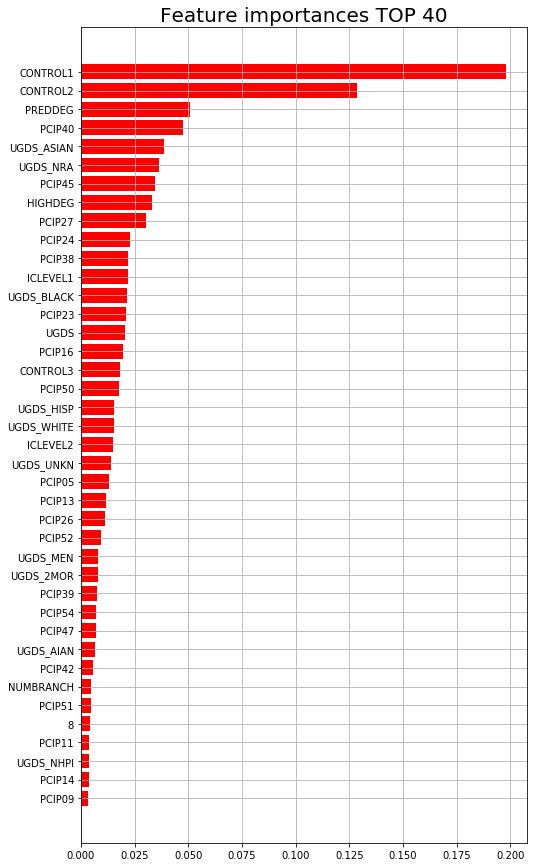

(0.19808296517045698, 'CONTROL1')
(0.12881621329096676, 'CONTROL2')
(0.050608552334756397, 'PREDDEG')
(0.047536494325732162, 'PCIP40')
(0.038911276789345424, 'UGDS_ASIAN')
(0.036214546052079494, 'UGDS_NRA')
(0.03466973009819907, 'PCIP45')
(0.033231506586904859, 'HIGHDEG')
(0.030227344244292454, 'PCIP27')
(0.022975497232628459, 'PCIP24')
(0.021929890729605467, 'PCIP38')
(0.021814927389013174, 'ICLEVEL1')
(0.021572586605162047, 'UGDS_BLACK')
(0.020882707491096084, 'PCIP23')
(0.020698423505012425, 'UGDS')
(0.019629986492107877, 'PCIP16')
(0.018376224050773573, 'CONTROL3')
(0.01788644356345603, 'PCIP50')
(0.015495877755865617, 'UGDS_HISP')
(0.015215359087997583, 'UGDS_WHITE')
(0.015072793386410335, 'ICLEVEL2')
(0.013988962268081523, 'UGDS_UNKN')
(0.013276823071330591, 'PCIP05')
(0.011709926761430603, 'PCIP13')
(0.011043375355394887, 'PCIP26')
(0.0094133888023390407, 'PCIP52')
(0.0078798940446218463, 'UGDS_MEN')
(0.0078468419180214681, 'UGDS_2MOR')
(0.007499343121574369, 'PCIP39')
(0.007127

In [160]:
# feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)

# plot 15 most important features 
plt.figure(figsize=(8, 15))
plt.barh(range(40), feature_importances[indices][:40], color="r", align="center")
plt.yticks(range(40), [x[1] for x in fimpotances][:40])
plt.title("Feature importances TOP 40", size=20)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()
# to show all features on the plot use:
#plt.barh(range(X_train.shape[1]), feature_importances[indices], color="r", align="center")
#plt.yticks(range(X_train.shape[1]), [x[1] for x in fimpotances])

# print all features (text)
for f in fimpotances:
    print(f)

The first 5 features are present in 50% of the splits. We can make a few observations about the use of featrues

- The tipe of institution play a crucial role in the cost (CONTROL1, CONTROL2, CONTROL3) accounting for almost 35% of the splits
- Another important feature is the types of degrees offereded 
- Non-resident aliens or Asian enrolments are also important in determining the price (we can't say in which way though, linear regression will give us more information in this sense)

## FINAL MODEL

We have now our final model. In order to see how it will do with unseen data we are going to use the test set:

In [162]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 4507.2285
final_rmse

4507.2285606554497

The final RSME for unseen data is 4507.23

This means that every predition has around 66% chance of being that range.

In order to get a better sense of the resuts we can plot the observed values and the prediction. If all the predictions were perfect all the point will be on the red line. In our case, except a few outliers, most of the points are close to the line which means we are making good predictions.

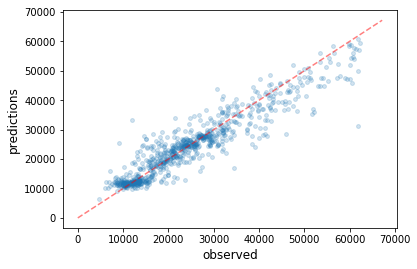

In [164]:
plt.scatter(y_test,final_predictions,alpha=0.2, s=15)
plt.xlabel('observed', fontsize=12)
plt.ylabel('predictions', fontsize=12)
plt.plot([0,(np.max(y_test) + 5000)],[0,(np.max(y_test) + 5000)], 'r--', alpha=0.5)
plt.show()

Additional comments / Things to think about:
    
* We could use linear regression to interpret each coefficient and have a better undertanding on how each feature affects the price
* Try to add/remove features
* Add other techniques to our pipeline (Scale features, PCA, other custom tranformers)
* Try to get more data, maybe using other years.


## The end